In [5]:
%pip install pandas
%pip install scikit-learn
%pip install plotly
%pip install numpy
%pip install matplotlib
%pip install nbformat
%pip install opencv-python
%pip install seaborn
%pip install scikit-image
%pip install keras
%pip install tensorflow
%pip install wandb
%pip install tqdm
%pip install tensorflow_hub

!wandb login 8e845d42ca64946d082c07402842921e4c70fea6


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.7 MB 7.9 MB/s eta 0:00

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Jonas\.netrc


In [11]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import plotly.express as px
from sklearn.model_selection import train_test_split
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
import wandb
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import random
import numpy as np
import tensorflow as tf

from sklearn.metrics import f1_score

import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [68]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion Recognition",

    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "RMSprop(learning_rate=1e-4)",
        "loss": "binary_crossentropy",
        "metric": ["accuracy"],
        "epoch": 5
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jonas14 (dspro2-group9). Use `wandb login --relogin` to force relogin


In [12]:
TRAIN_DIR = ('../../data/raw/train')
TEST_DIR = ('../../data/raw/test')

In [37]:
def load_data(dir_path, img_size):
    X = []
    y = []
    labels = []
    for label_idx, label_name in enumerate(sorted(os.listdir(dir_path))):
        if not label_name.startswith('.'):
            label_path = os.path.join(dir_path, label_name)
            for file_name in sorted(os.listdir(label_path)):
                if not file_name.startswith('.'):
                    img_path = os.path.join(label_path, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA).astype('float32') / 255
                    X.append(img)
                    y.append(label_idx)
                    labels.append(label_name)
    X = np.array(X)
    y = np.array(y)
    labels = np.array(labels)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [17]:
IMG_SIZE= (48, 48)

In [62]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

28709 images loaded from ../../data/raw/train directory.


In [61]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

7178 images loaded from ../../data/raw/test directory.


In [63]:
from keras.utils import to_categorical

y_train -= 1
Y_train = to_categorical(y_train, num_classes = 6)
Y_train.shape

(28709, 6)

In [65]:
y_test -= 1
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7178, 6)

In [66]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False, 
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [72]:
def deep_model(model, X_train, Y_train, epochs, batch_size):
   
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1
                       ,callbacks=[WandbMetricsLogger(log_freq=5)])
    return history

In [73]:
epochs = 40
batch_size = 64

history = deep_model(model, X_train, Y_train, epochs, batch_size)

wandb.finish()

Epoch 1/40


wandb: ERROR Unable to log learning rate.


449/449 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.2435 - loss: 0.4773
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.2520 - loss: 0.4228
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.2481 - loss: 0.4232
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.2479 - loss: 0.4235
Epoch 5/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.2550 - loss: 0.4227
Epoch 6/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.2585 - loss: 0.4224
Epoch 7/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 564s 1s/step - accuracy: 0.2500 - loss: 0.4233
Epoch 8/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 564s 1s/step - accuracy: 0.2482 - loss: 0.4226
Epoch 9/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.2566 - loss: 0.4220
Epoch 10/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.2523 - loss: 0.4222
Epoch 11/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - accuracy: 0.2486 - loss: 0.4227
Epoch 12/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/ste

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step
Test Accuracy = 0.50


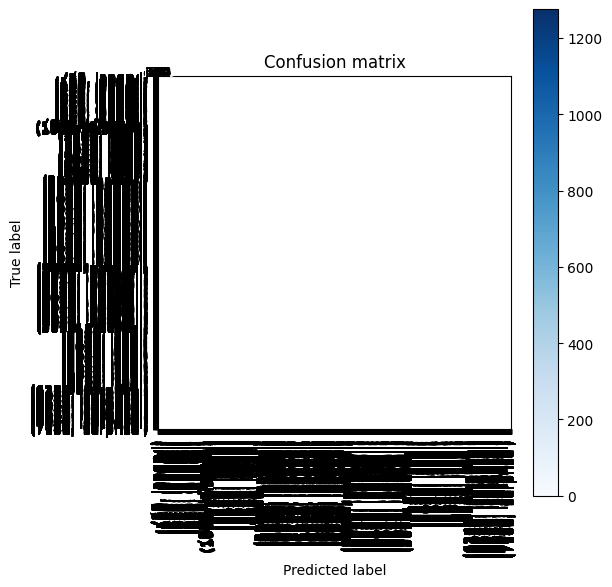

In [77]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
test_labels_dict = {i: label for i, label in enumerate(test_labels)}
cm = plot_confusion_matrix(confusion_mtx, classes=list(test_labels_dict.items()), normalize=False)